In [3]:
import json
import matplotlib.pyplot as plt

def plot(experiments, title, labels = ["Base", "Attack 1", "Attack 2"]):

    metric_names = ["loss", "accuracy", "kappa", "f1", "roc"]
    
    fig, axes = plt.subplots(3, 2, figsize=(20, 15))
    fig.suptitle(title, fontsize=20)
    axes = axes.flatten()

    # Load all experiments
    all_data = {}

    for exp in experiments:
        with open(f"results/{exp}.json", "r") as f:
            metrics = json.load(f)
        rounds = sorted([int(k) for k in metrics.keys()])
        all_data[exp] = {
            "rounds": rounds,
            "metrics": metrics
        }

    # Plotting
    for i, metric_name in enumerate(metric_names):
        ax = axes[i]
        for exp, label in zip(experiments, labels):
            rounds = all_data[exp]["rounds"]
            metrics = all_data[exp]["metrics"]

            values = [metrics[str(r)][metric_name] for r in rounds]
            ax.plot(rounds, values, label=label)

        # Titles: min for loss, max for others
        all_values = []
        for exp in experiments:
            all_values.extend([all_data[exp]["metrics"][str(r)][metric_name] for r in all_data[exp]["rounds"]])

        if metric_name == "loss":
            title_stats = str(round(min(all_values), 2))
        else:
            title_stats = str(round(max(all_values), 2))

        ax.set_title(f"{metric_name} {title_stats}", fontsize=14)
        ax.set_xlabel("Round")
        ax.set_ylabel(metric_name)
        ax.legend()

    axes[-1].axis("off")
    plt.tight_layout()
    plt.show()



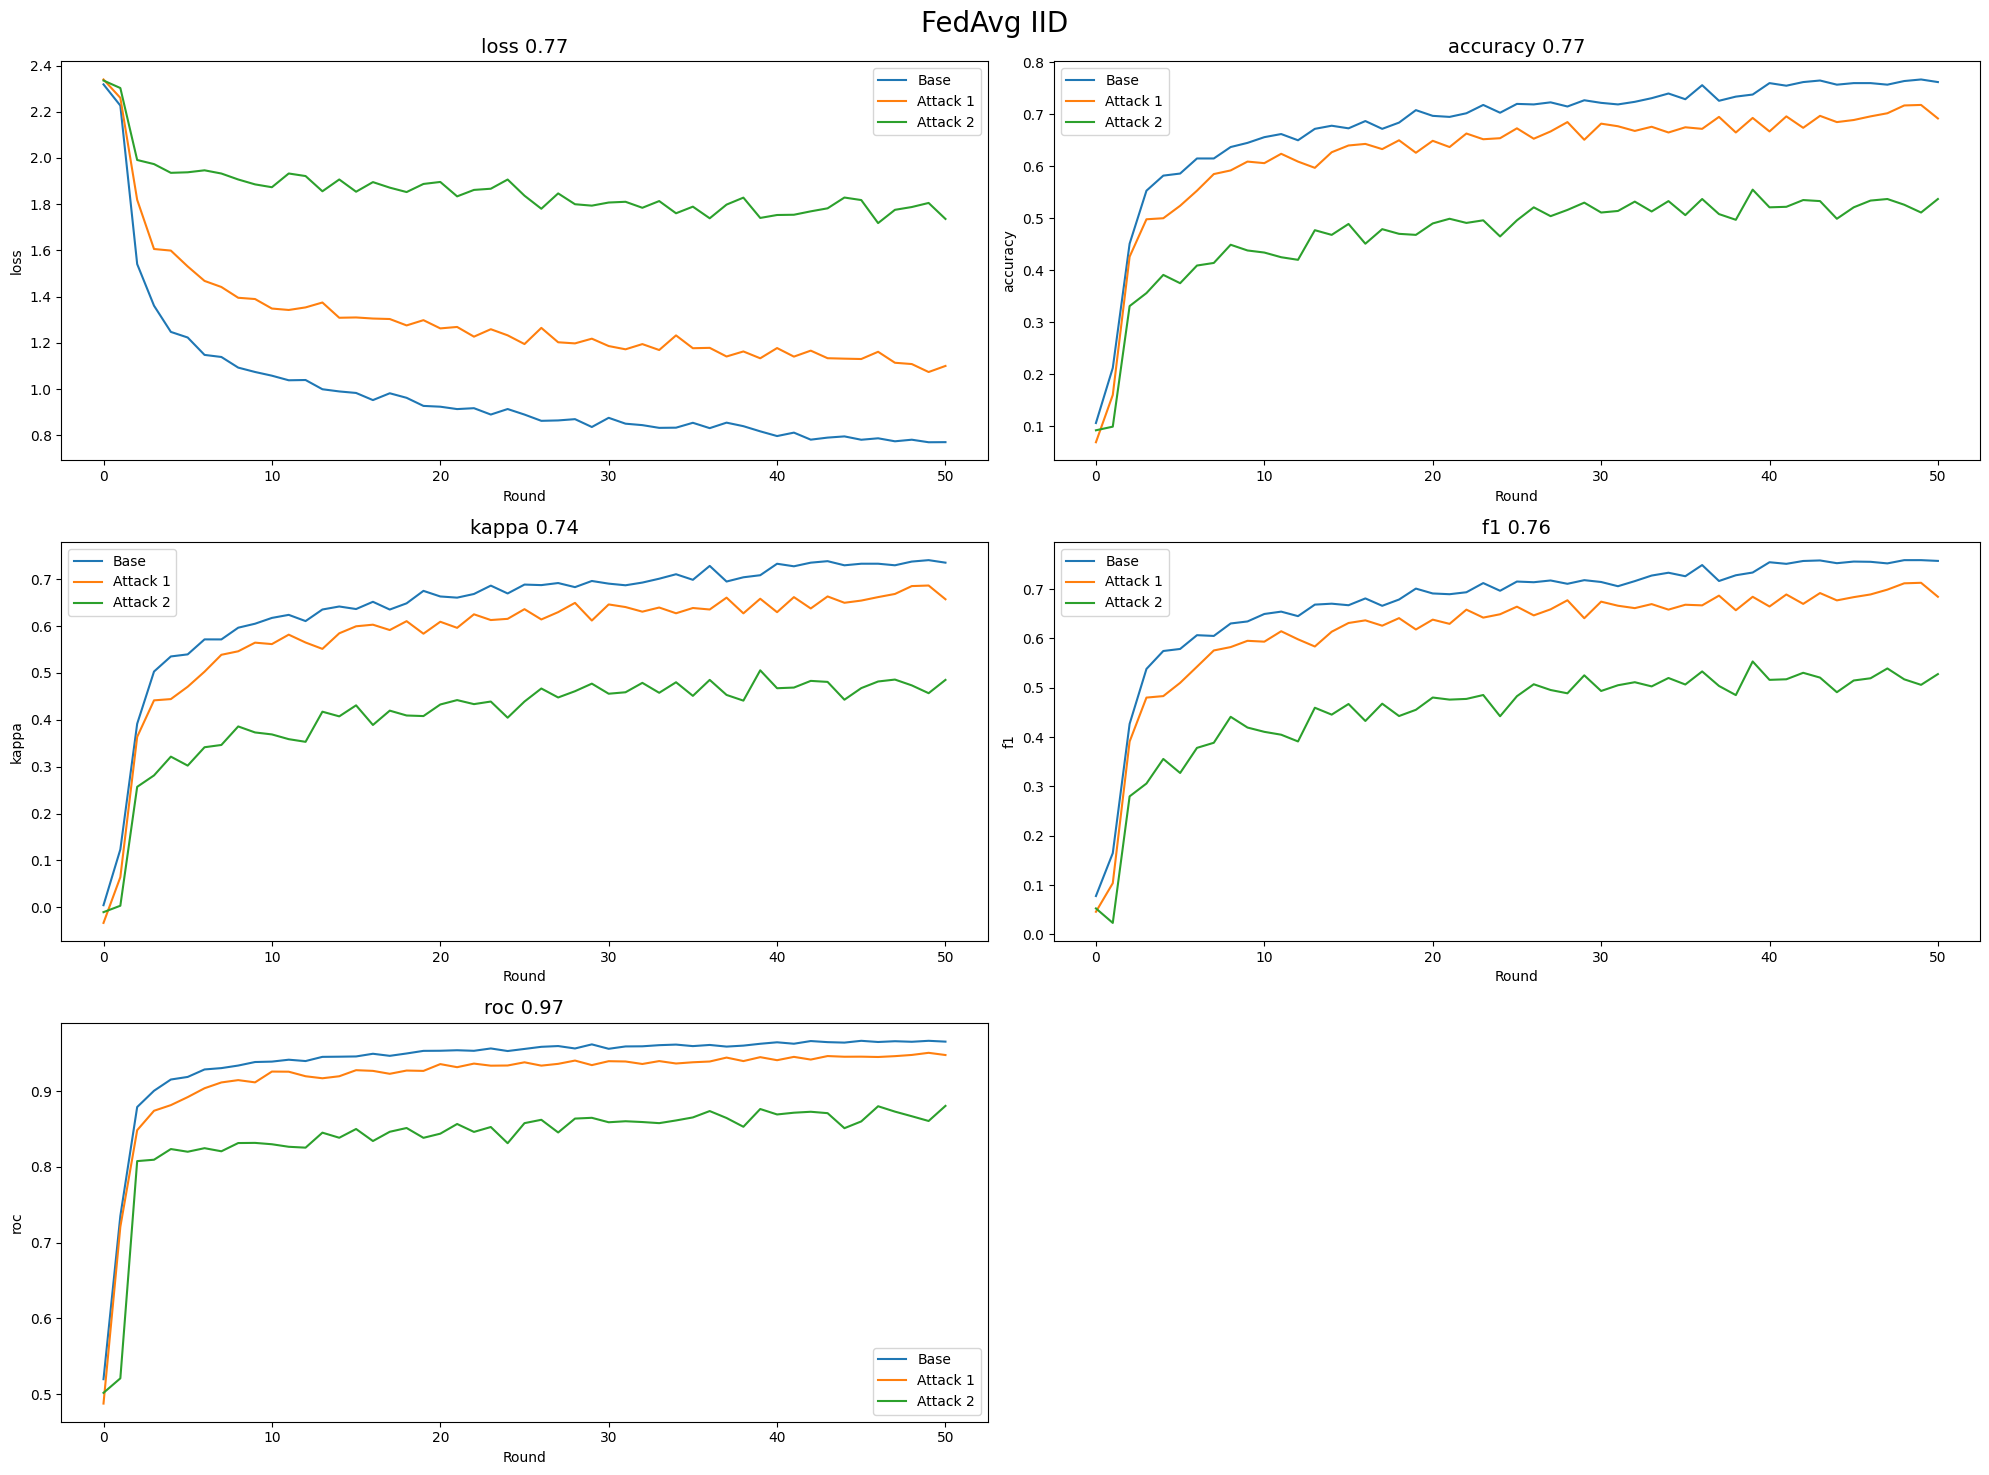

In [4]:
# FedAvg IID
plot(['results_fedavg_iid_attack0', 'results_fedavg_iid_attack1', 'results_fedavg_iid_attack2'], "FedAvg IID")

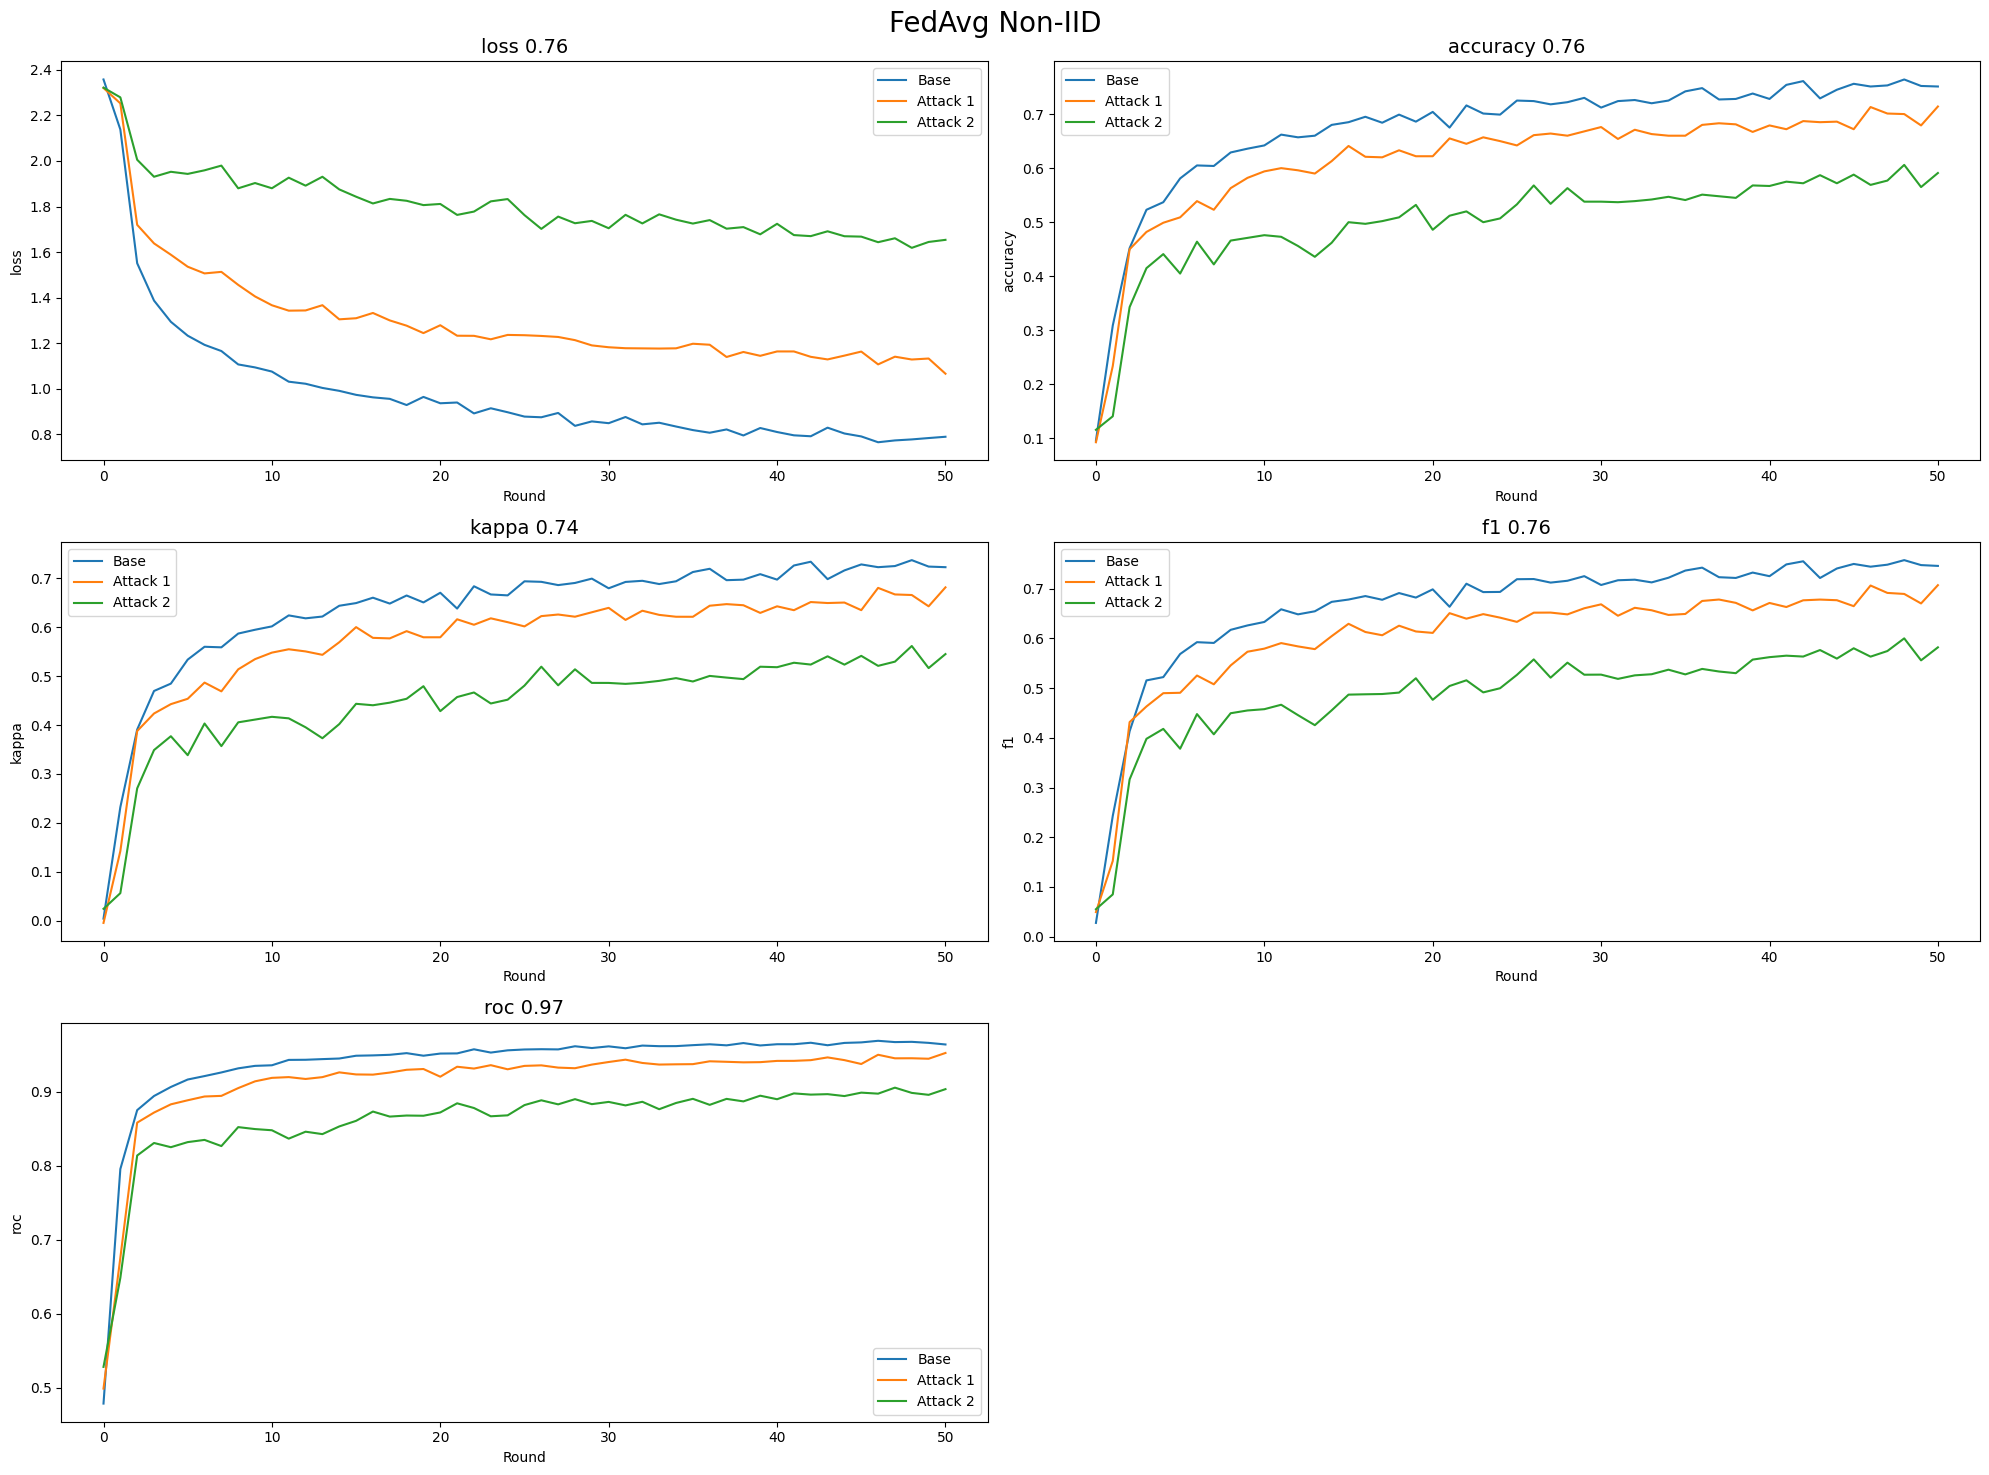

In [74]:
# FedAvg Non-IID
plot(['results_fedavg_non_iid_attack0',
      'results_fedavg_non_iid_attack1',
      'results_fedavg_non_iid_attack2'], "FedAvg Non-IID")


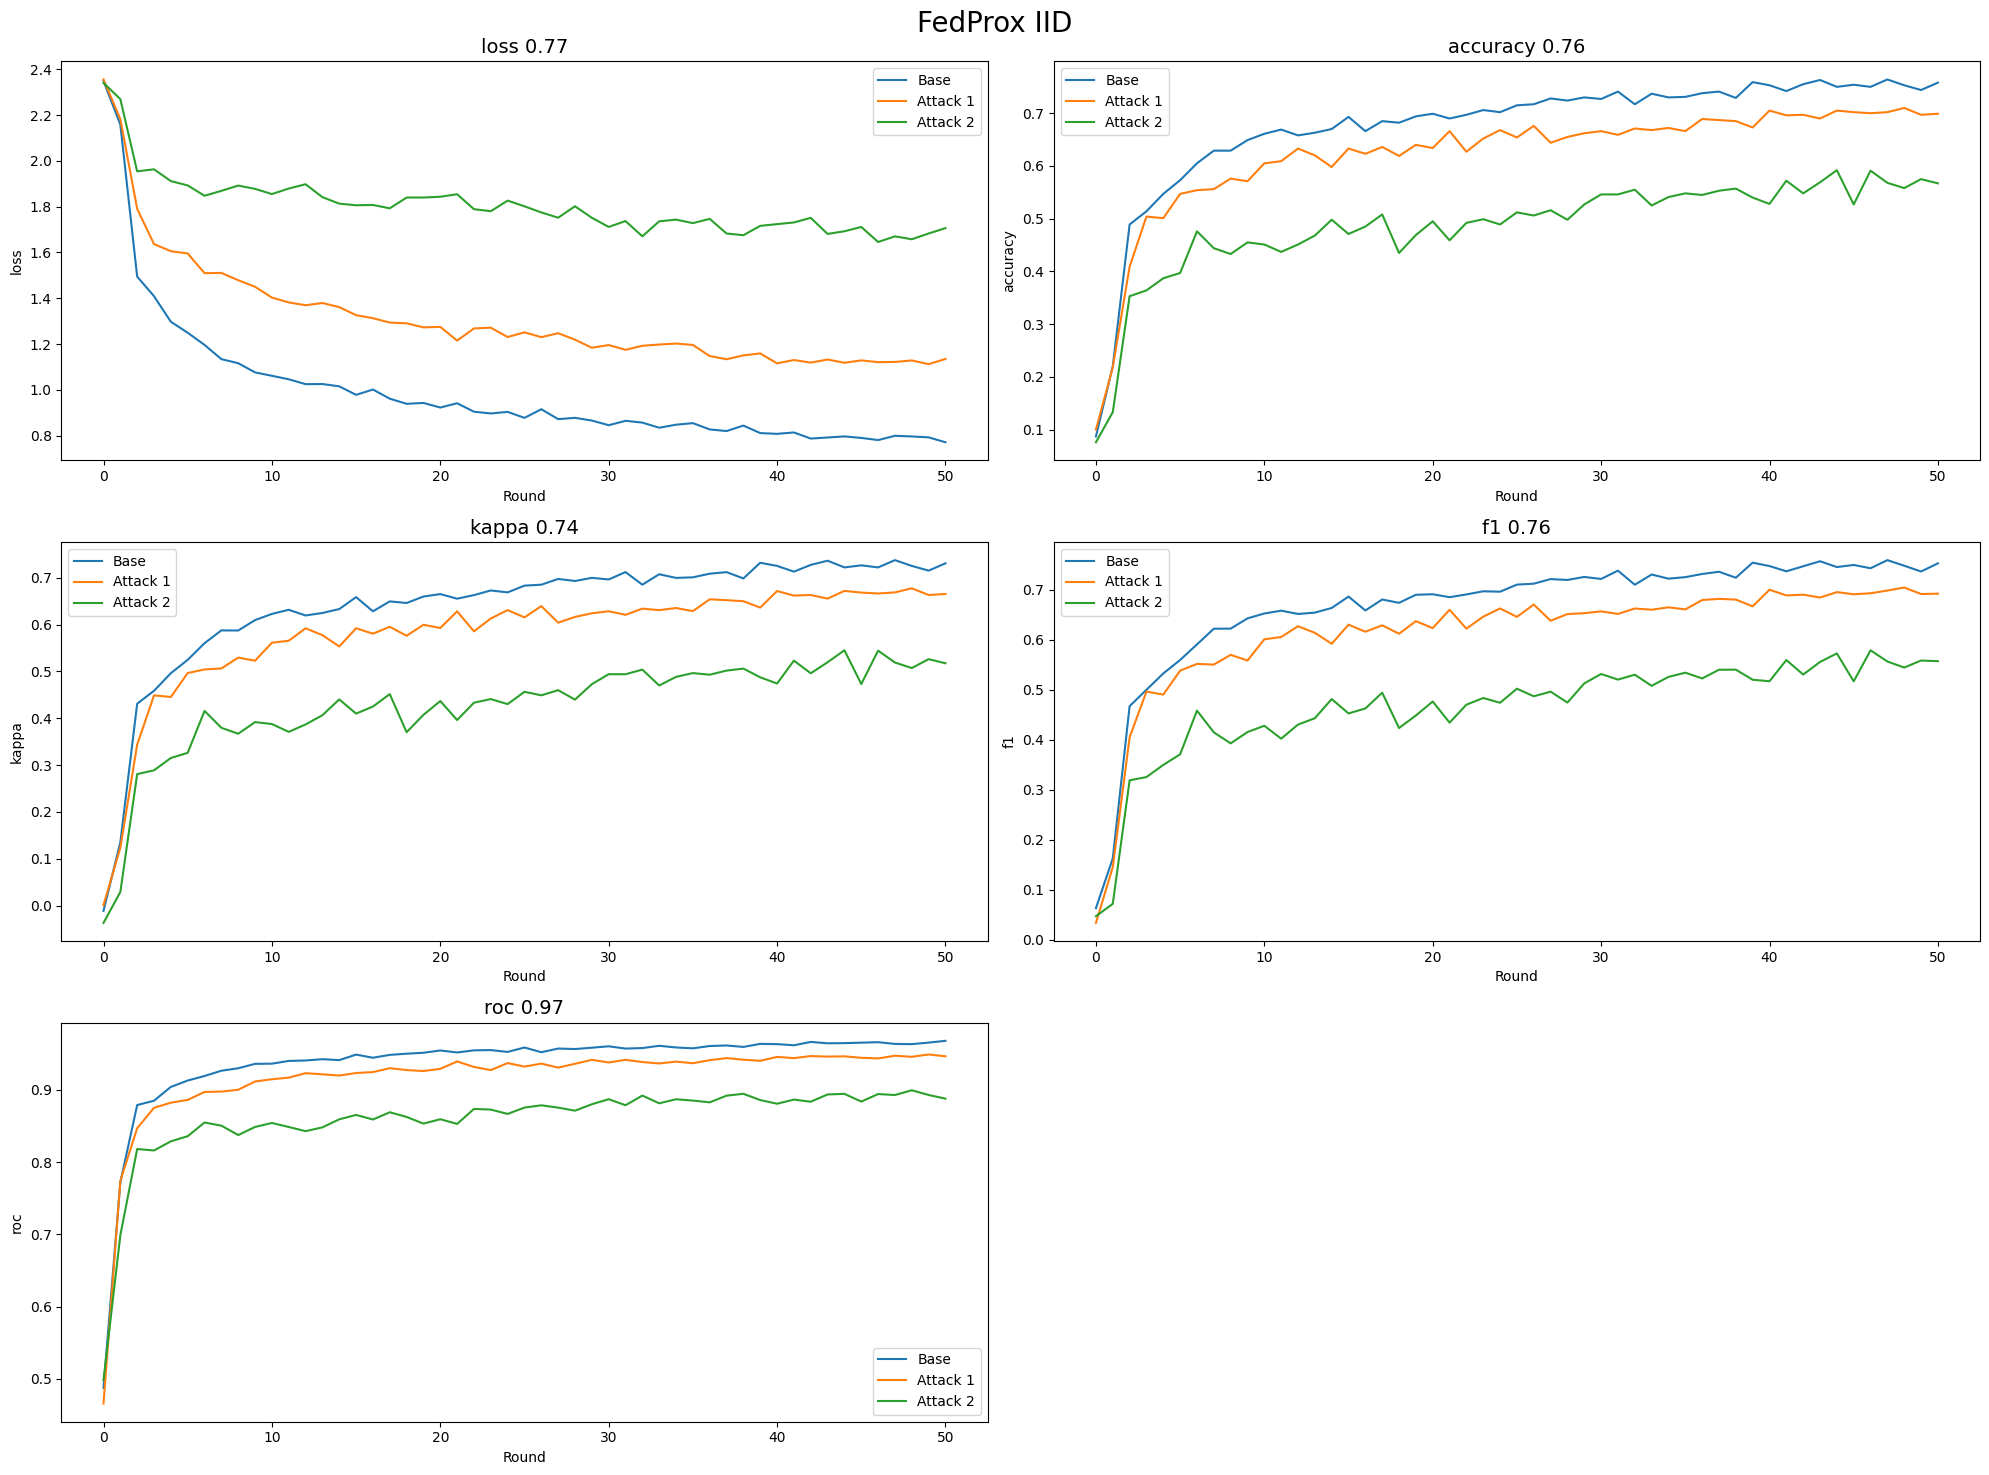

In [75]:
# FedProx IID
plot(['results_fedprox_iid_attack0',
      'results_fedprox_iid_attack1',
      'results_fedprox_iid_attack2'], "FedProx IID")

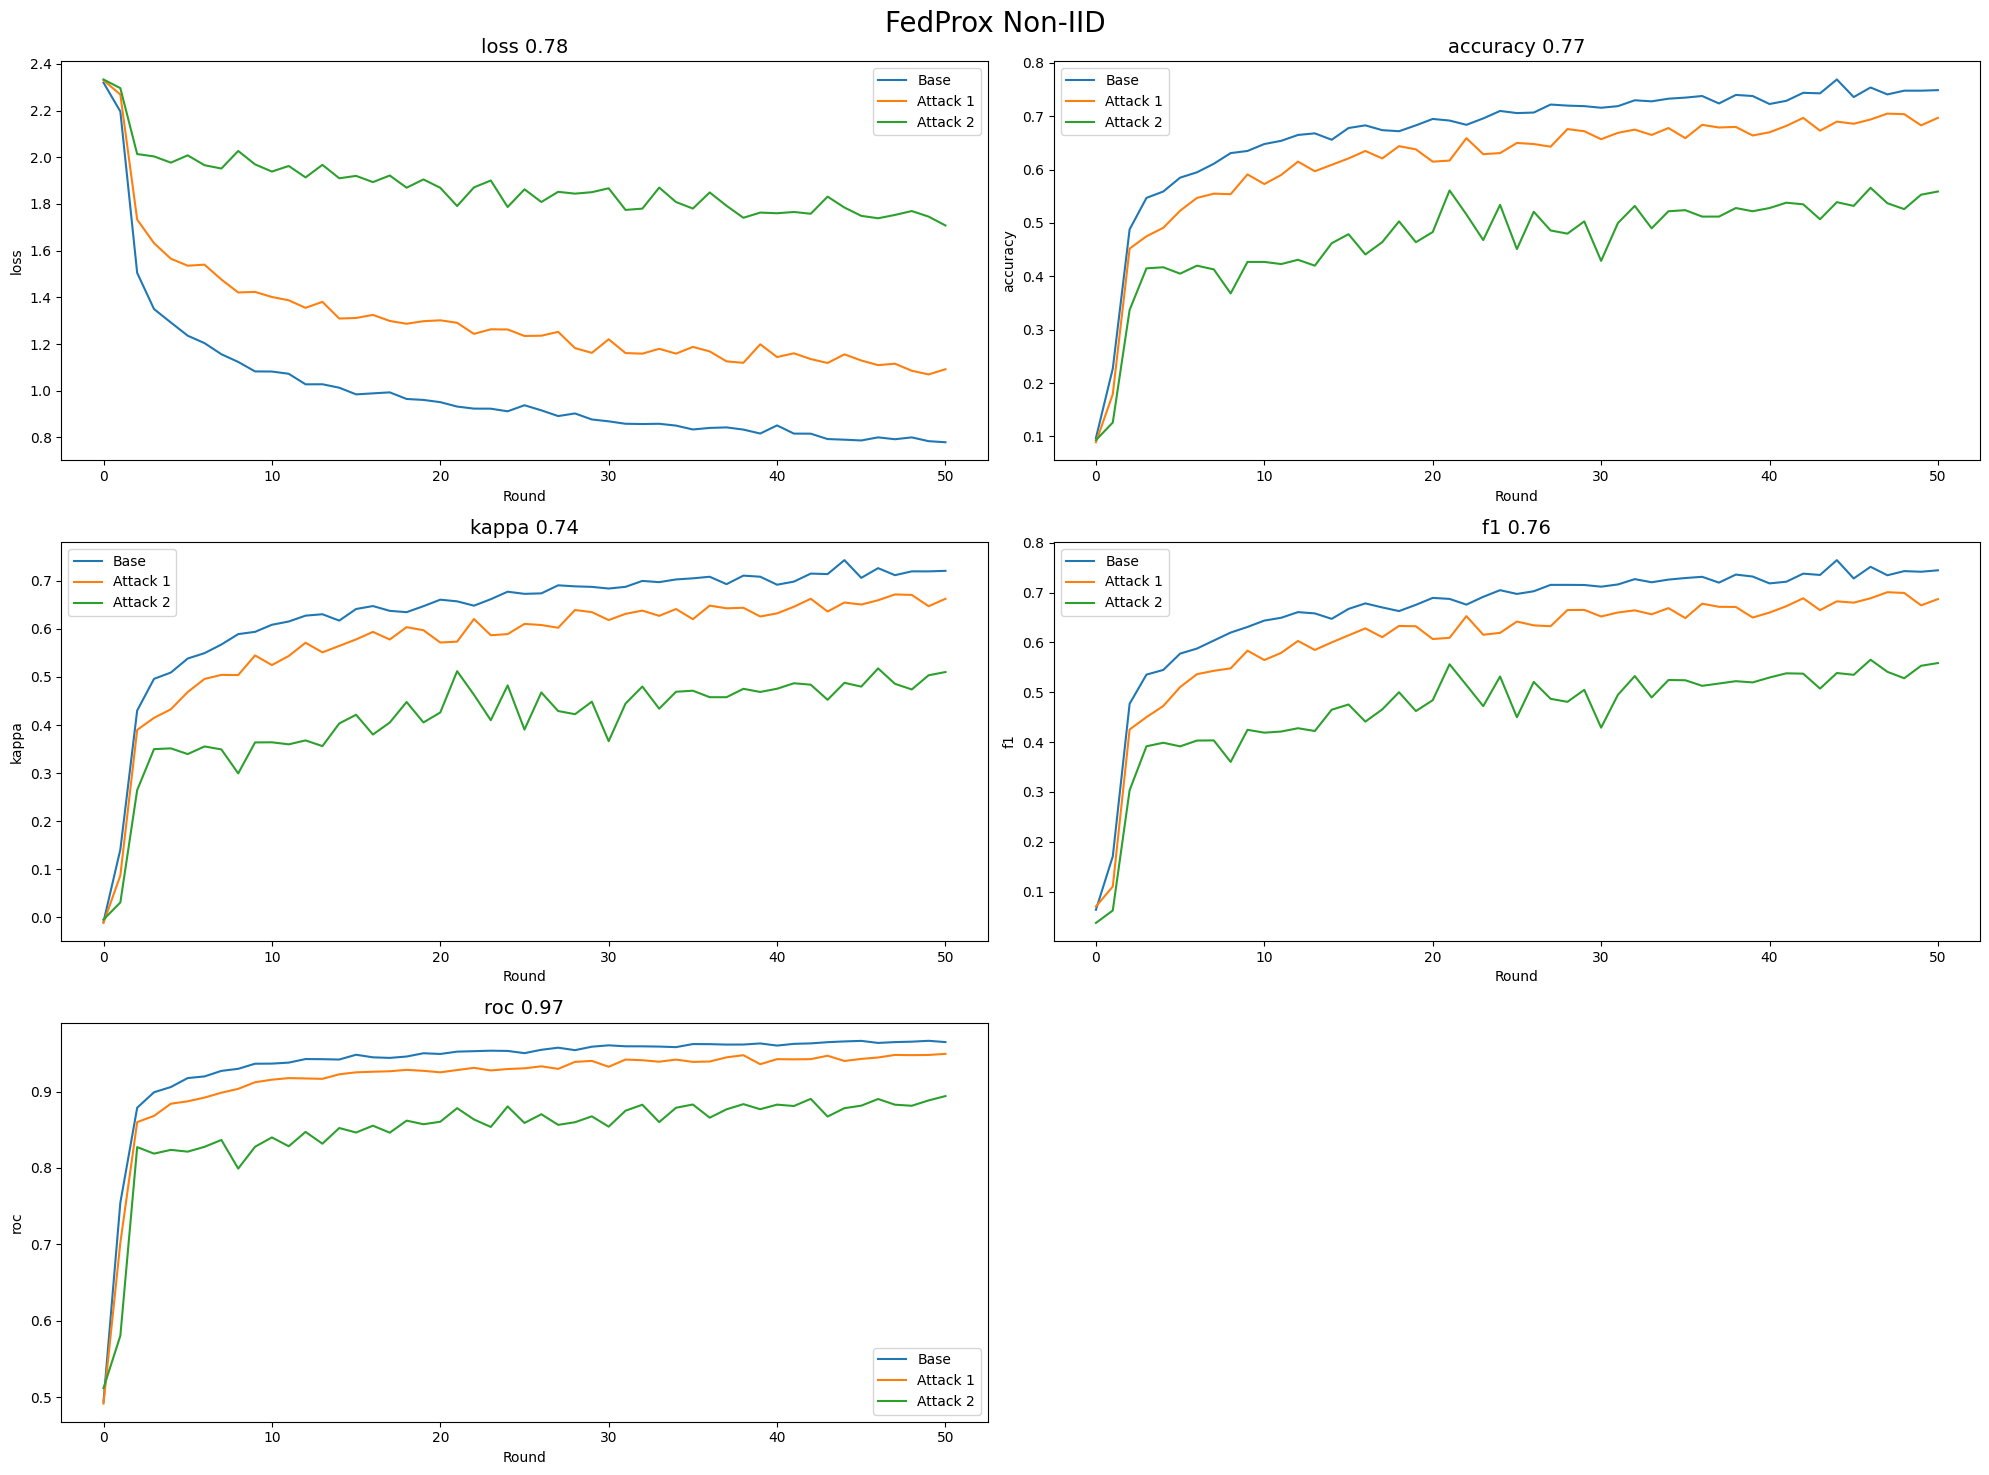

In [76]:
# FedProx Non-IID
plot(['results_fedprox_non_iid_attack0',
      'results_fedprox_non_iid_attack1',
      'results_fedprox_non_iid_attack2'], "FedProx Non-IID")

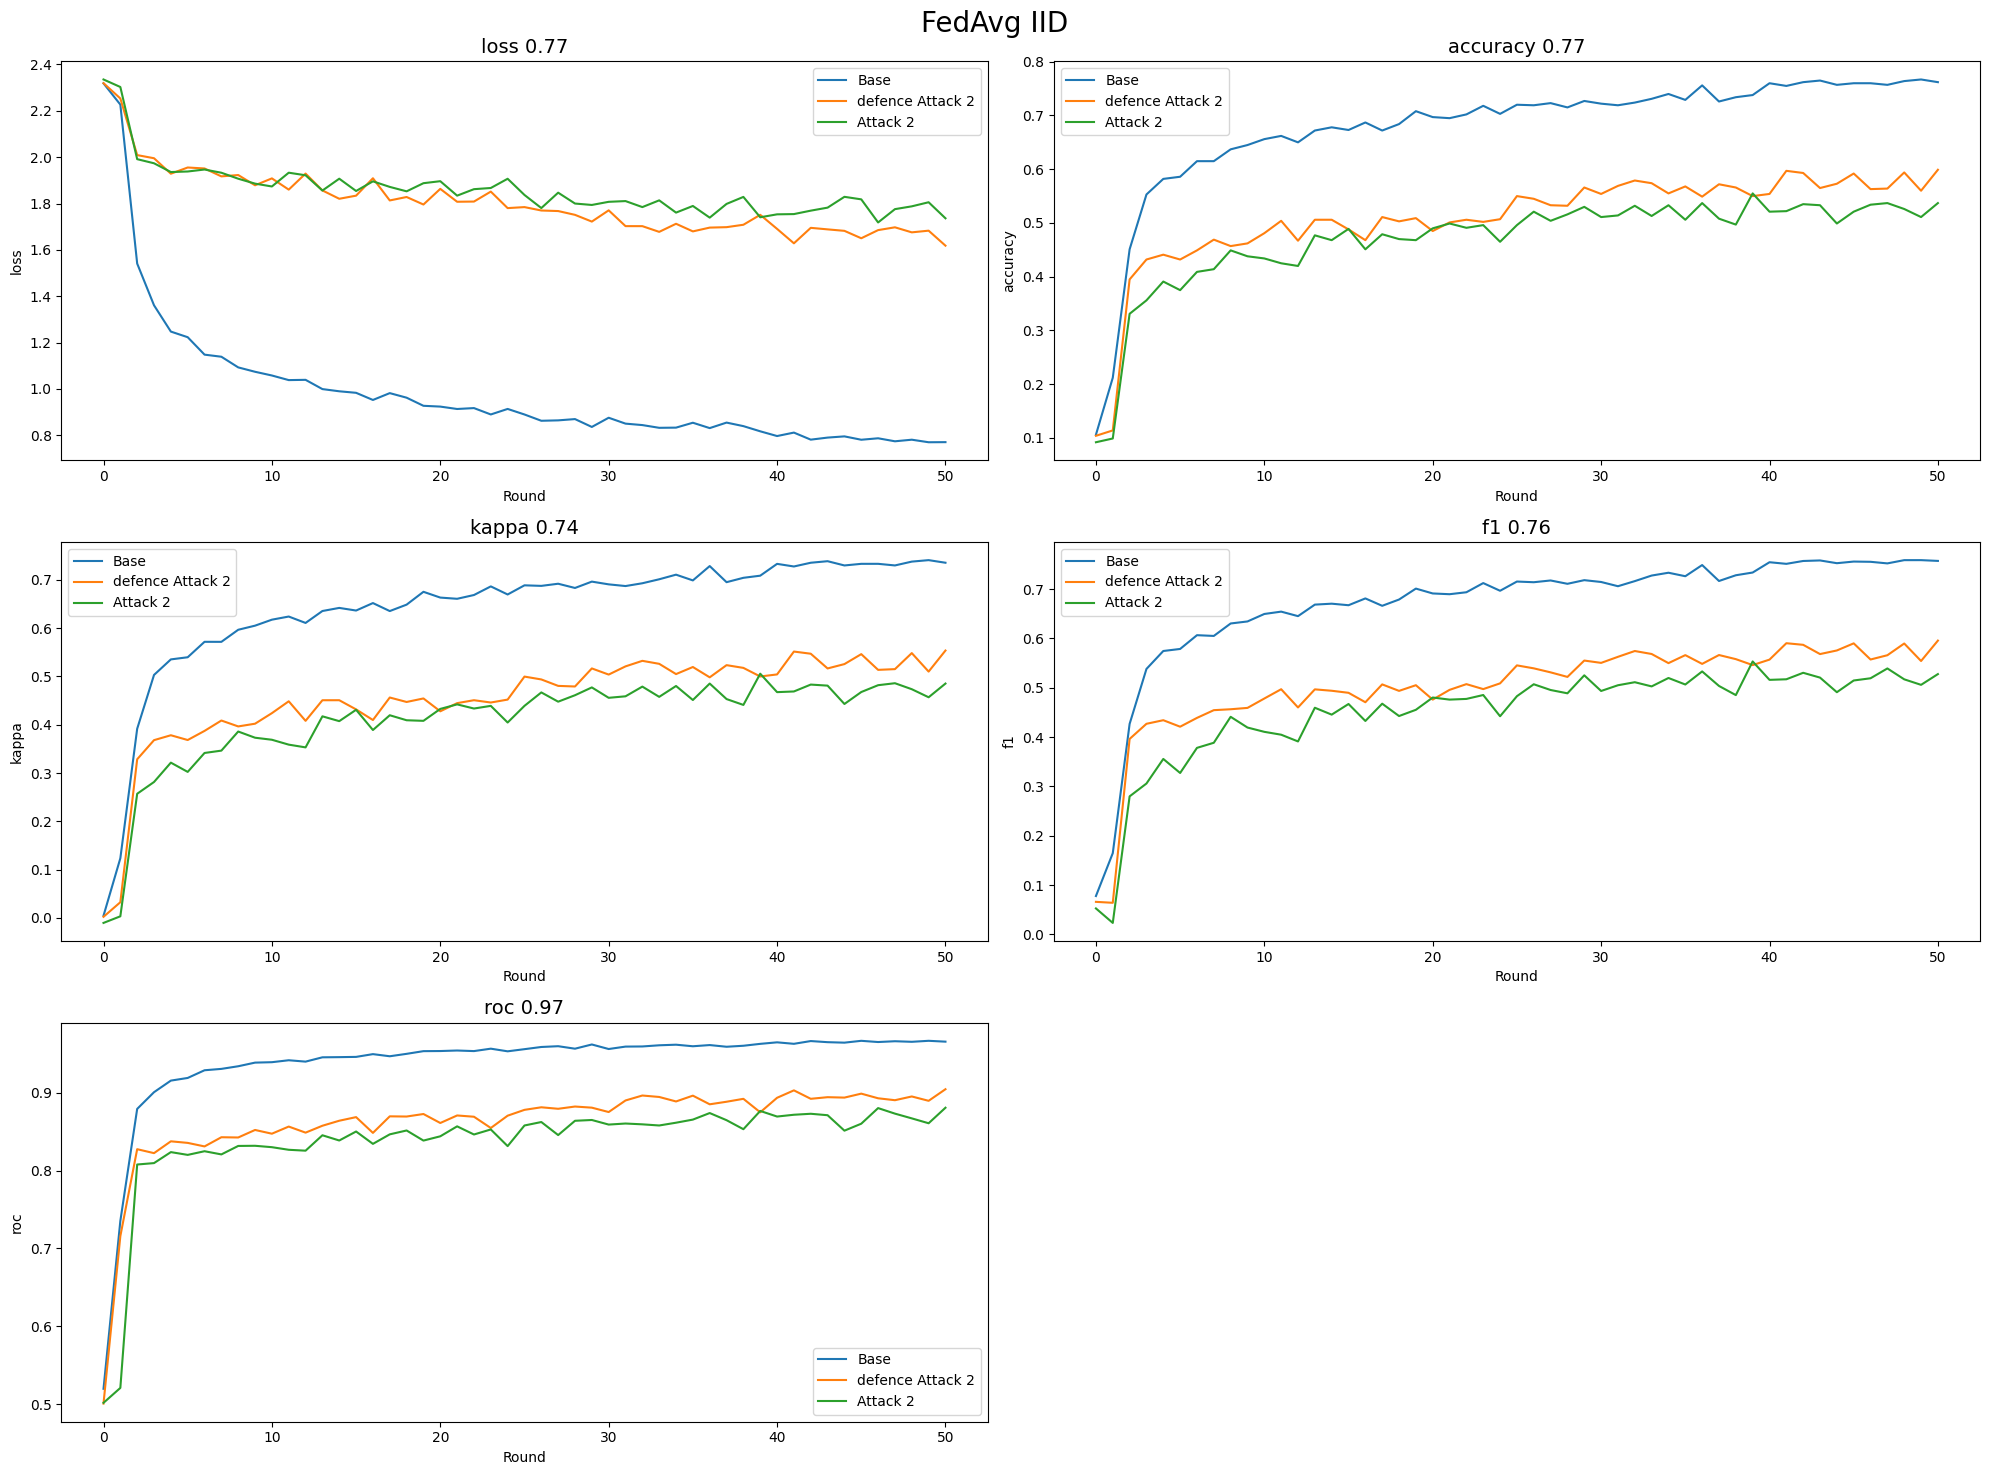

In [17]:
plot(['results_fedavg_iid_attack0', 'defence2', 'results_fedavg_iid_attack2'], "FedAvg IID", ["Base", "defence Attack 2", "Attack 2"])